In [1]:
import itertools

import jax
import jax.scipy as jsp
import jax.numpy as jnp

In [2]:
lmbda = 1/25
positions = [-4, -2, 0, 2, 4]
mu = jnp.array([list(prod) for prod in itertools.product(positions, positions)])
sigma = 0.03 * jnp.eye(2)

def logprob_fn(x, *_):
    return lmbda * jsp.special.logsumexp(jax.scipy.stats.multivariate_normal.logpdf(x, mu, sigma))

def sample_fn(rng_key):
    choose_key, sample_key = jax.random.split(rng_key)
    samples = jax.random.multivariate_normal(sample_key, mu, sigma)
    return jax.random.choice(choose_key, samples)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'Samples from a mixture of 25 normal distributions')

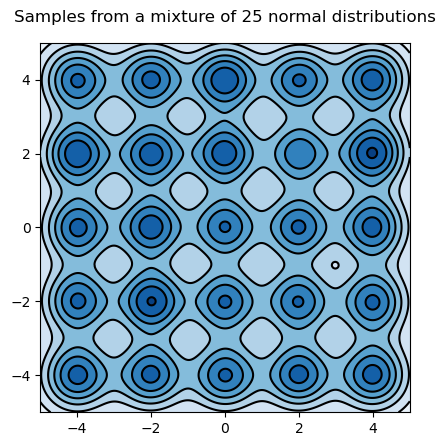

In [3]:
import matplotlib.pylab as plt

import numpy as np
from scipy.stats import gaussian_kde


rng_key = jax.random.PRNGKey(0)
samples = jax.vmap(sample_fn)(jax.random.split(rng_key, 10_000))

xmin, ymin = -5, -5
xmax, ymax = 5, 5

nbins = 300j
x, y = samples[:, 0], samples[:, 1]
xx, yy = np.mgrid[xmin:xmax:nbins, ymin:ymax:nbins]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig, ax = plt.subplots()
cfset = ax.contourf(xx, yy, f, cmap='Blues')
ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')

plt.rcParams['axes.titlepad'] = 15.
plt.title("Samples from a mixture of 25 normal distributions")

In [4]:
import blackjax
import jax
from fastprogress import progress_bar


# 50k iterations
num_training_steps = 50000
schedule_fn = lambda k: 0.05 * k ** (-0.55)
schedule = [schedule_fn(i) for i in range(1, num_training_steps+1)]

grad_fn = lambda x, _: jax.grad(logprob_fn)(x)
sgld = blackjax.sgld(grad_fn)

rng_key = jax.random.PRNGKey(3)
init_position = -10 + 20 * jax.random.uniform(rng_key, shape=(2,))

position = init_position
sgld_samples = []
for i in progress_bar(range(num_training_steps)):
    _, rng_key = jax.random.split(rng_key)
    position = sgld.step(rng_key, position, 0, schedule[i])
    sgld_samples.append(position)

In [24]:
sgld?

Type:        SamplingAlgorithm
String form: SamplingAlgorithm(init=<function sgld.__new__.<locals>.init_fn at 0x7f7510297920>, step=<function sgld.__new__.<locals>.step_fn at 0x7f7510296f20>)
Length:      2
File:        /mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/blackjax/base.py
Docstring:  
A pair of functions that represents a MCMC sampling algorithm.

Blackjax sampling algorithms are implemented as a pair of pure functions: a
kernel, that takes a new samples starting from the current state, and an
initialization function that creates a kernel state from a chain position.

As they represent Markov kernels, the kernel functions are pure functions
and do not have internal state. To save computation time they also operate
on states which contain the chain state and additional information that
needs to be carried over for the next step.

init:
    A pure function which when called with the initial position and the
    target density probability funct

Cyclical SGLD

In [5]:
from typing import NamedTuple


class ScheduleState(NamedTuple):
    step_size: float
    do_sample: bool

def build_schedule(
    num_training_steps,
    num_cycles=4,
    initial_step_size=1e-3,
    exploration_ratio=0.25,
):
    cycle_length = num_training_steps // num_cycles

    def schedule_fn(step_id):
        do_sample = False
        if ((step_id % cycle_length)/cycle_length) >= exploration_ratio:
            do_sample = True

        cos_out = jnp.cos(jnp.pi * (step_id % cycle_length) / cycle_length) + 1
        step_size = 0.5 * cos_out * initial_step_size

        return ScheduleState(step_size, do_sample)

    return schedule_fn

Text(0.5, 1.0, 'Training schedule for Cyclical SGLD')

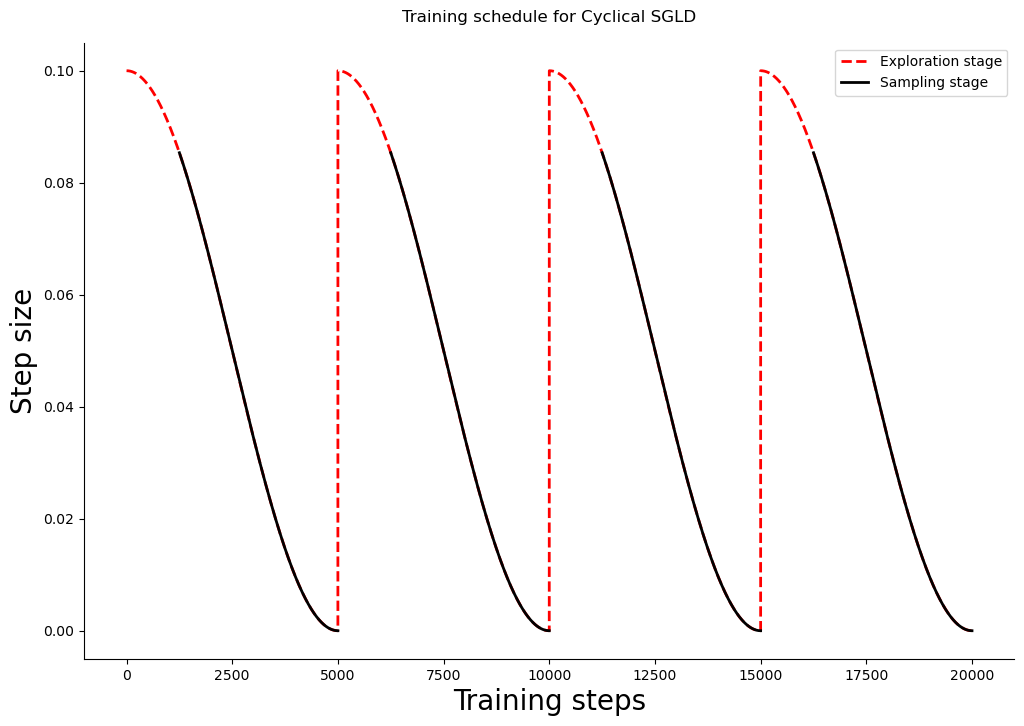

In [6]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

schedule_fn = build_schedule(20000, 4, 1e-1)
schedule = [schedule_fn(i) for i in range(20000)]

step_sizes = np.array([step.step_size for step in schedule])
do_sample = np.array([step.do_sample for step in schedule])

sampling_points = np.ma.masked_where(~do_sample, step_sizes)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(step_sizes, lw=2, ls="--", color="r", label="Exploration stage")
ax.plot(sampling_points, lw=2, ls="-", color="k", label="Sampling stage")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_xlabel("Training steps", fontsize=20)
ax.set_ylabel("Step size", fontsize=20)
plt.legend()
plt.title("Training schedule for Cyclical SGLD")

In [8]:
from typing import NamedTuple

import blackjax
import optax

from jax.tree_util import tree_structure
from optax._src.base import OptState


class CyclicalSGMCMCState(NamedTuple):
    """State of the Cyclical SGMCMC sampler.
    """
    position: tree_structure
    opt_state: OptState


def cyclical_sgld(grad_estimator_fn, loglikelihood_fn):

    # Initialize the SgLD step function
    sgld = blackjax.sgld(grad_estimator_fn)
    sgd = optax.sgd(1.)

    def init_fn(position):
        opt_state = sgd.init(position)
        return CyclicalSGMCMCState(position, opt_state)

    def step_fn(rng_key, state, minibatch, schedule_state):
        """Cyclical SGLD kernel."""

        def step_with_sgld(current_state):
            rng_key, state, minibatch, step_size = current_state
            new_position = sgld.step(rng_key, state.position, minibatch, step_size)
            return CyclicalSGMCMCState(new_position, state.opt_state)

        def step_with_sgd(current_state):
            _, state, minibatch, step_size = current_state
            grads = grad_estimator_fn(state.position, 0)
            rescaled_grads = - 1. * step_size * grads
            updates, new_opt_state = sgd.update(rescaled_grads, state.opt_state, state.position)
            new_position = optax.apply_updates(state.position, updates)
            return CyclicalSGMCMCState(new_position, new_opt_state)

        new_state = jax.lax.cond(
            schedule_state.do_sample,
            step_with_sgld,
            step_with_sgd,
            (rng_key, state, minibatch, schedule_state.step_size)
        )

        return new_state

    return init_fn, step_fn

In [9]:
import jax
from fastprogress import progress_bar


# 50k iterations
# M = 30
# initial step size = 0.09
# ratio exploration = 1/4
num_training_steps = 50000
schedule_fn = build_schedule(num_training_steps, 30, 0.09, 0.25)
schedule = [schedule_fn(i) for i in range(num_training_steps)]

grad_fn = lambda x, _: jax.grad(logprob_fn)(x)
init, step = cyclical_sgld(grad_fn, logprob_fn)

rng_key = jax.random.PRNGKey(3)
init_position = -10 + 20 * jax.random.uniform(rng_key, shape=(2,))
init_state = init(init_position)


state = init_state
cyclical_samples = []
for i in progress_bar(range(num_training_steps)):
    _, rng_key = jax.random.split(rng_key)
    state = jax.jit(step)(rng_key, state, 0, schedule[i])
    if schedule[i].do_sample:
        cyclical_samples.append(state.position)

Text(0.5, 1.0, 'Trajectory with Cyclical SGLD')

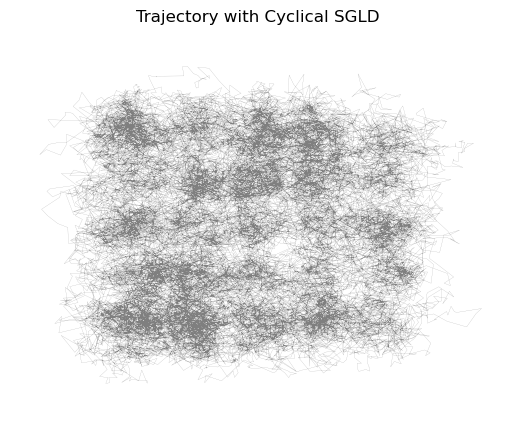

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = [sample[0] for sample in cyclical_samples]
y = [sample[1] for sample in cyclical_samples]

ax.plot(x, y, 'k-', lw=0.1, alpha=0.5)
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])

plt.axis('off')
plt.title("Trajectory with Cyclical SGLD")

Text(0.5, 1.0, 'Samples from a mixture of 25 normal distributions')

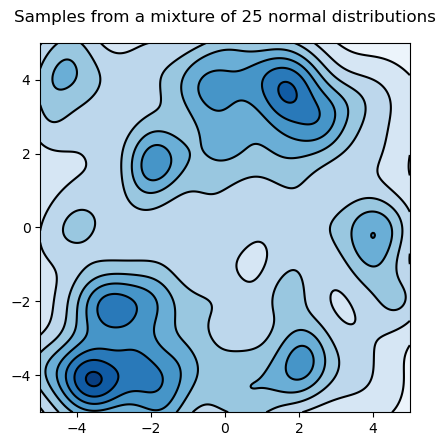

In [11]:
import matplotlib.pylab as plt

import numpy as np
from scipy.stats import gaussian_kde

xmin, ymin = -5, -5
xmax, ymax = 5, 5

nbins = 300j
x = [sample[0] for sample in cyclical_samples]
y = [sample[1] for sample in cyclical_samples]
xx, yy = np.mgrid[xmin:xmax:nbins, ymin:ymax:nbins]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig, ax = plt.subplots()
cfset = ax.contourf(xx, yy, f, cmap='Blues')
ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')

plt.rcParams['axes.titlepad'] = 15.
plt.title("Samples from a mixture of 25 normal distributions")

Another SGLD example

In [19]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp


def gaussian_mixture_model(mu=-5.0, sigma=5.0, gamma=20.0):
    def sample_fn(rng_key, num_samples):
        key1, key2, key3 = jax.random.split(rng_key, 3)
        prob_mixture = jax.random.bernoulli(key1, p=0.5, shape=(num_samples, 1))
        mixture_1 = jax.random.normal(key2, shape=(num_samples, 1)) * sigma + mu
        mixture_2 = jax.random.normal(key3, shape=(num_samples, 1)) * sigma + gamma - mu
        #print(prob_mixture * mixture_1 + (1 - prob_mixture) * mixture_2)
        return prob_mixture * mixture_1 + (1 - prob_mixture) * mixture_2

    def logprior_fn(position):
        return 0

    def loglikelihood_fn(position, x):
        mixture_1 = jax.scipy.stats.norm.logpdf(x, loc=position, scale=sigma)
        mixture_2 = jax.scipy.stats.norm.logpdf(x, loc=-position + gamma, scale=sigma)
        return jsp.special.logsumexp(jnp.array([mixture_1, mixture_2])) + jnp.log(0.5)

    return sample_fn, logprior_fn, loglikelihood_fn


sample_fn, logprior_fn, loglikelihood_fn = gaussian_mixture_model()

In [20]:
data_size = 1000

rng_key = jax.random.PRNGKey(888)
rng_key, sample_key = jax.random.split(rng_key)
X_data = sample_fn(sample_key, data_size)

Text(0.5, 1.0, 'Data')

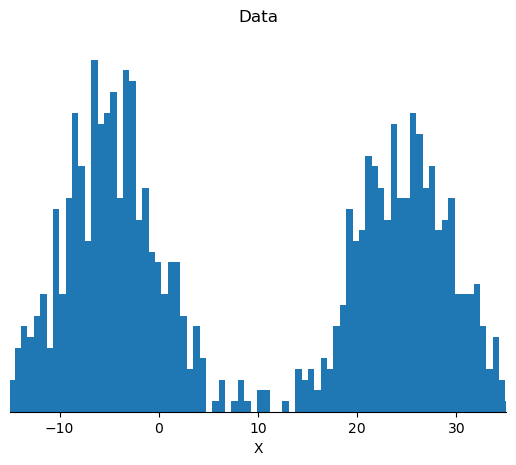

In [21]:
import matplotlib.pylab as plt

ax = plt.subplot(111)
ax.hist(X_data.squeeze(), 100)
ax.set_xlabel("X")
ax.set_xlim(left=-15, right=35)

ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.title("Data")

In [15]:
from fastprogress import progress_bar

import blackjax
import blackjax.sgmcmc.gradients as gradients

# Specify hyperparameters for SGLD
total_iter = 10_000
thinning_factor = 10

batch_size = 100
lr = 1e-3
temperature = 50.0

init_position = 10.0


# Build the SGDL sampler
grad_fn = gradients.grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.sgld(grad_fn)


# Initialize and take one step using the vanilla SGLD algorithm
position = init_position
sgld_sample_list = jnp.array([])

pb = progress_bar(range(total_iter))
for iter_ in pb:
    rng_key, batch_key, sample_key = jax.random.split(rng_key, 3)
    data_batch = jax.random.shuffle(batch_key, X_data)[:batch_size, :]
    position = sgld.step(sample_key, position, data_batch, lr, temperature)
    if iter_ % thinning_factor == 0:
        sgld_sample_list = jnp.append(sgld_sample_list, position)
        pb.comment = f"| position: {position: .2f}"

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/random.py:410: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)
/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/random.py:410: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


In [3]:
import blackjax.sgmcmc.gradients as gradients

gradients.grad_estimator?

Signature:
gradients.grad_estimator(
    logprior_fn: Callable,
    loglikelihood_fn: Callable,
    data_size: int,
) -> Callable
Docstring: Build a simple estimator for the gradient of the log-density.
File:      /mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/blackjax/sgmcmc/gradients.py
Type:      function

Text(0.5, 0.98, 'Stochastic gradient Langevin dynamics (SGLD)')

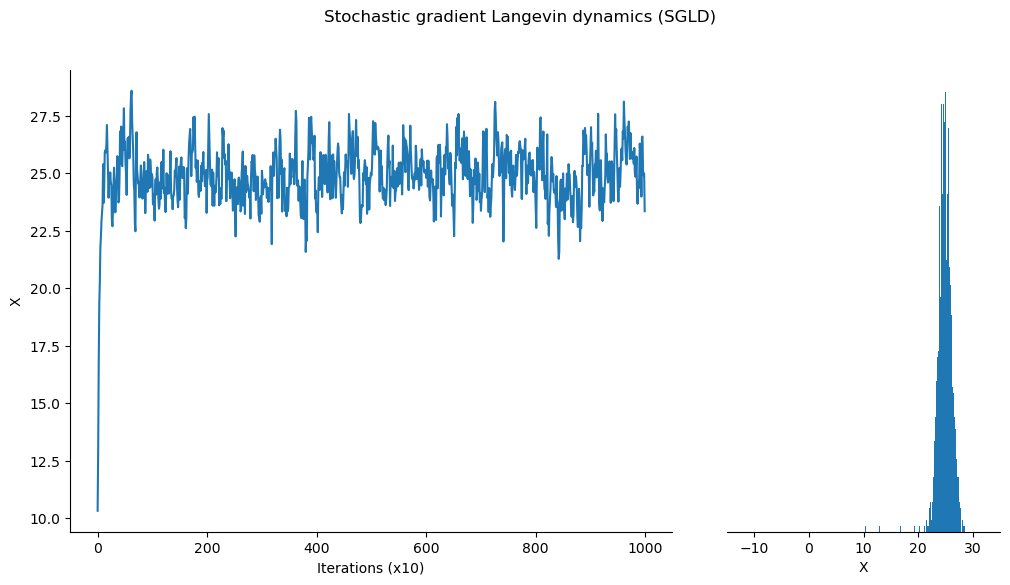

In [16]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 6))

G = gridspec.GridSpec(1, 3)

# Trajectory
ax = plt.subplot(G[0, :2])
ax.plot(sgld_sample_list, label="SGLD")
ax.set_xlabel(f"Iterations (x{thinning_factor})")
ax.set_ylabel("X")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


# Histogram
ax = plt.subplot(G[0, 2])
ax.hist(sgld_sample_list, 100)
ax.set_xlabel("X")
ax.set_xlim(left=-15, right=35)

ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)


plt.suptitle("Stochastic gradient Langevin dynamics (SGLD)")